In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 3, 96, 96-> 32, 96, 96
        self.pool1 = nn.MaxPool2d(4) # 32, 24, 24
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 64, 24, 24
        self.pool2 = nn.MaxPool2d(4) # 64, 6, 6

        self.dense1 = nn.Linear(64 * 6 * 6, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, 5)

        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.dense1.bias)
        nn.init.zeros_(self.dense2.bias)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense3.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.softmax(self.dense3(x), dim=1)
        return x

In [18]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

EPISODES = 500

env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, 
               domain_randomize=False, continuous=False)

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

discount = 0.99
losses = []
rewards = []
max_reward = 0

for e in range(EPISODES):
    observation, info = env.reset()

    log_probs = []
    episode_rewards = []
    total_episode_reward = 0

    episode_over = False
    while not episode_over:

        state = torch.from_numpy(observation).view(1, 3, 96, 96).float() / 255.0

        # action = env.action_space.sample()  # agent policy that uses the observation and info
        probs = policy(state)
        action = torch.multinomial(probs, num_samples=1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        log_probs.append(torch.log(probs[0, action]))
        episode_rewards.append(reward)
        total_episode_reward += reward

        episode_over = terminated or truncated
    
    rewards.append(total_episode_reward)
    if total_episode_reward > max_reward:
        max_reward = total_episode_reward
        print(f"New max of {max_reward} in episode {e + 1}")

    returns = []
    R = 0
    for r in reversed(episode_rewards):
        R = r + discount * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = 0
    optimizer.zero_grad()
    for log_prob, R in zip(log_probs, returns):
        loss += -log_prob * R
        
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())

    if (e + 1) % 100 == 0:
        print(f"Episodes {(e - 99, e)}: Avg Loss- {sum(losses[e-99:e+1])/100}, Avg Return- {sum(rewards[e-99:e+1])/100}")
        
env.close()

New max of 16.607773851589883 in episode 11
New max of 48.60681114551006 in episode 12
New max of 55.03875968992134 in episode 42
Episodes (0, 99): Avg Loss- -2.974943829923868, Avg Return- -54.08150808986447
New max of 62.19107806691534 in episode 146
Episodes (100, 199): Avg Loss- -7.404736984372139, Avg Return- -53.918015700870725
Episodes (200, 299): Avg Loss- -17.331113237142564, Avg Return- -60.01400733989881
New max of 102.18579234972727 in episode 375
New max of 145.5516014234898 in episode 376
Episodes (300, 399): Avg Loss- -24.121932175159454, Avg Return- -59.49236361070205
New max of 160.71428571429036 in episode 401
New max of 184.74576271186828 in episode 427
Episodes (400, 499): Avg Loss- -15.662380075454712, Avg Return- -32.23044114525127


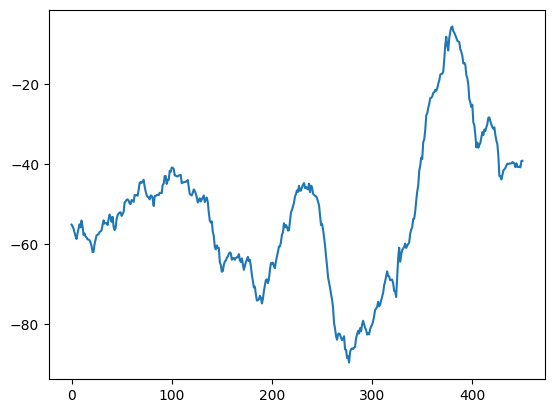

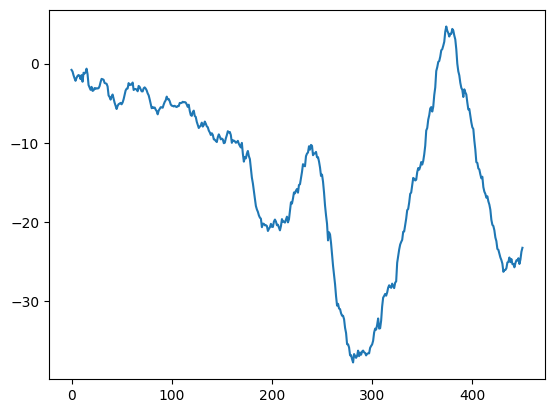

In [20]:
import numpy as np

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, 50))
plt.figure()
plt.plot(moving_average(losses, 50))

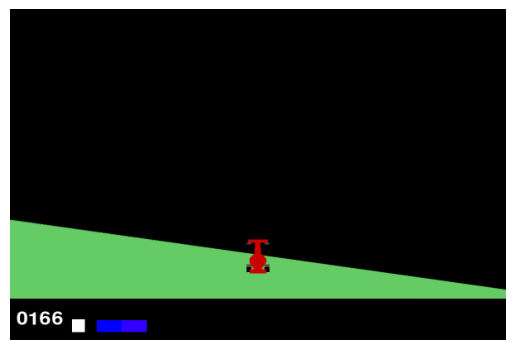

Final Return: 66.41634980988692
Average Return over 100 episodes: -32.7949321633869


In [25]:
show = True
rewards = []

for _ in range(100):
    observation, info = env.reset()
    episode_reward = 0
    episode_over = False
    while not episode_over:
        if show:
            frame = env.render()
            clear_output(wait=True)
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            time.sleep(0.002)

        with torch.no_grad():
            probs = policy(torch.from_numpy(observation).view(1, 3, 96, 96).float() / 255.0)
            action = torch.argmax(probs, dim=1).item()

        observation, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        episode_over = terminated or truncated

    if show:
        show = False
        print(f"Final Return: {episode_reward}")

    rewards.append(episode_reward)

print(f"Average Return over 100 episodes: {sum(rewards) / 100}")

env.close()

In [26]:
torch.save(policy.state_dict(), "models/car_racing/REINFORCE_-32")